# Project 3 Behavioural Cloning
## Background


## Rationale

## Plan

## Conclusion



### Load Data

In [1]:
import cv2
import csv
import numpy as np
from PIL import Image

In [2]:
from __future__ import print_function
import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.noise import GaussianNoise
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
# Recommended Flipping
from keras.layers import Lambda
from keras.layers import Cropping2D

In [35]:
def prepImage(path):
    source_path = path
    filename = source_path.split('/')[-1]
    current_path = './data/IMG/' + filename
    return cv2.imread(current_path, 1) # 0 = grayscale, 1 = Colour


In [36]:

lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

lines = lines[1:]
        
images = []
measurements = []
for line in lines:
    # IMAGES
    img_center = prepImage(line[0])
    images.append(img_center)
    
    img_left = prepImage(line[1])
    images.append(img_left)
    
    img_right = prepImage(line[2])
    images.append(img_right)
    
    # STEERING
    steering_center = float(line[3])
    measurements.append(steering_center)
    
    correction = 0.2 # this is a parameter to tune
    steering_left = steering_center + correction
    measurements.append(steering_left)
    steering_right = steering_center - correction
    measurements.append(steering_right)
    
        
# X_train = np.array(images)
# y_train = np.array(measurements)   


In [24]:
        
# Flip the Images for more data   
augmented_images, augmented_measurements = [] ,[]
for image, measurement in zip(images, measurements ):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image, 1))
    augmented_measurements.append(measurement*-1.0)  
        
X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)   

del(images)
del(measurements)
del(augmented_images)
del(augmented_measurements)

In [25]:
import sys
sys.getsizeof(X_train) / 1e9

7.405977744

In [27]:
# # ## Split into train and validation

# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


### Image Augmentation

In [29]:
# from keras.preprocessing.image import ImageDataGenerator

# # Create Data Generator
# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True) #,
#     #rotation_range=20, # Could cause an issue for steering
#     #width_shift_range=0.2, 
#     #height_shift_range=0.2 ) #,
#     # horizontal_flip=True) # need to flip steering too

# # compute quantities required for featurewise normalization
# # (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)




In [5]:
# Recommended Flipping
from keras.layers import Lambda
from keras.layers import Cropping2D

Using TensorFlow backend.


# BASIC MODEL (No Generator)

In [34]:
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5),
    ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=0)
]

batch_size = 256
epochs = 10
learn_rate = 0.001
drop_rate = 0.3

model = Sequential()
# Normalise
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
# Crop
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(3,160,320)))

# Conv Layer 1
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_rate))

# Conv Layer 2
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_rate))

# Conv Layer 3
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_rate))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(drop_rate))
model.add(Dense(1))

model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=learn_rate))

# fits the model on batches with real-time data augmentation:
history_object = model.fit(X_train, 
          y_train, 
          validation_split=0.2,
          shuffle=True,
          epochs=epochs,
          callbacks=callbacks)

# Save model in callbacks
# model.save('model.h5')

Train on 38572 samples, validate on 9644 samples
Epoch 1/10
38572/38572 [==============================] - 68s - loss: 0.0176 - val_loss: 0.0119
Epoch 2/10
38572/38572 [==============================] - 67s - loss: 0.0109 - val_loss: 0.0111
Epoch 3/10
38572/38572 [==============================] - 67s - loss: 0.0100 - val_loss: 0.0103
Epoch 4/10
38572/38572 [==============================] - 67s - loss: 0.0096 - val_loss: 0.0101
Epoch 5/10
38572/38572 [==============================] - 67s - loss: 0.0092 - val_loss: 0.0101
Epoch 6/10
38572/38572 [==============================] - 67s - loss: 0.0089 - val_loss: 0.0105
Epoch 7/10
38572/38572 [==============================] - 67s - loss: 0.0088 - val_loss: 0.0103
Epoch 8/10
38572/38572 [==============================] - 67s - loss: 0.0085 - val_loss: 0.0106
Epoch 9/10
38572/38572 [==============================] - 67s - loss: 0.0083 - val_loss: 0.0101
Epoch 10/10
38572/38572 [==============================] - 67s - loss: 0.0082 - val_los

## Do some plotting

In [ ]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

# Next Level Model (Generator)

# Generator model

In [13]:
def prepImage(path, img_dir):
    filename = path.split('/')[-1]
    current_path = img_dir + filename
    return cv2.imread(current_path, 1) # 0 = grayscale, 1 = Colour


In [14]:
import os
import csv

# driving_log = './data/driving_log.csv'
# img_dir = './data/IMG/'
# driving_log = './car_training_data/driving_log.csv'
# img_dir = './car_training_data/IMG/'
driving_log = './data/driving_log_combined.csv'
img_dir = './data/IMG/'

samples = []
with open(driving_log) as csvfile:
    reader = csv.reader(csvfile)
    # Skip header row
    next(reader)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [26]:
import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle

# Hyperparameters - leave these in this position
batch_size = 128
epochs = 10
learn_rate = 0.001
drop_rate = 0.3

## Add multi camera angels (left/right) + Augmentation# Flip the Images for more data   

def generator(samples, batch_size=32):
    num_samples = len(samples)
    batch_size = batch_size // 2 # to deal with image augmentation
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                
                # IMAGES
                img_center = prepImage(batch_sample[0], img_dir)
                images.append(img_center)
                
                img_left = prepImage(batch_sample[1], img_dir)
                images.append(img_left)
                
                img_right = prepImage(batch_sample[2], img_dir)
                images.append(img_right)
                
                
                # STEERING
                steering_center = float(batch_sample[3])
                angles.append(steering_center)

                correction = 1 # this is a parameter to tune 0.2
                steering_left = steering_center + correction
                angles.append(steering_left)
                steering_right = steering_center - correction
                angles.append(steering_right)
        
            # AUGMENTATION (Flip the Images for more data)
            augmented_images = []
            augmented_angles = [] 
            for image, angle in zip(images, angles):
                augmented_images.append(image)
                augmented_angles.append(angle)
                augmented_images.append(cv2.flip(image, 1))
                augmented_angles.append(angle*-1.0)  

            X_train = np.array(augmented_images)
            y_train = np.array(augmented_angles)
            
            yield shuffle(X_train, y_train)
            
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)




In [35]:

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5),
    ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=0)
]

img_h, img_w, ch = 160, 320, 3
top_crop, bottom_crop = 50, 20
left_crop, right_crop = 0, 0

model = Sequential()

# # Normalise
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(img_h,img_w,ch)))
# Crop
model.add(Cropping2D(cropping=((top_crop, bottom_crop), (left_crop, right_crop)) )) # , input_shape=(3,160,320)))
# Add Random Noise - Prevents overfitting
model.add( GaussianNoise(stddev=1.0) )

# Conv Layer 1
model.add(Conv2D(24, (5, 5), strides=(2,2), activation='relu', padding='same')) # filters = 8
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_rate))

# Conv Layer 2
model.add(Conv2D(36, (5, 5), strides=(2,2), activation='relu', padding='same')) # filters = 16
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_rate))

# Conv Layer 3
model.add(Conv2D(48, (3, 3), strides=(1,1), activation='relu', padding='same')) # filters = 32
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_rate))

# Conv Layer 4
model.add(Conv2D(64, (3, 3), strides=(1,1), activation='relu', padding='same')) # filters = 64
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_rate))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
#model.add(Dropout(drop_rate))
model.add(Dense(1))

model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=learn_rate))

# num train samples * 3 for centre, left, right camera, *2 for augmentation
batch_step_factor = 3*2 # Need 3*2 to use full dataset each epoch

history_object = model.fit_generator(train_generator,
                    # num train samples * 3 for centre, left, right camera, *2 for augmentation
                    steps_per_epoch= (len(train_samples)*batch_step_factor) / batch_size, 
                    validation_data=validation_generator, 
                    validation_steps= (len(validation_samples)*batch_step_factor) / batch_size, 
                    epochs=epochs,
                    callbacks=callbacks)


Epoch 1/10
521/520 [==============================] - 283s - loss: 0.1933 - val_loss: 0.0259
Epoch 2/10
521/520 [==============================] - 282s - loss: 0.0279 - val_loss: 0.0153
Epoch 3/10
521/520 [==============================] - 282s - loss: 0.0209 - val_loss: 0.0128
Epoch 4/10
521/520 [==============================] - 282s - loss: 0.0198 - val_loss: 0.0133
Epoch 5/10
521/520 [==============================] - 282s - loss: 0.0178 - val_loss: 0.0117
Epoch 6/10
521/520 [==============================] - 282s - loss: 0.0169 - val_loss: 0.0110
Epoch 7/10
521/520 [==============================] - 281s - loss: 0.0161 - val_loss: 0.0109
Epoch 8/10
521/520 [==============================] - 282s - loss: 0.0152 - val_loss: 0.0115
Epoch 9/10
521/520 [==============================] - 283s - loss: 0.0155 - val_loss: 0.0114
Epoch 10/10
521/520 [==============================] - 282s - loss: 0.0146 - val_loss: 0.0104


dict_keys(['val_loss', 'loss'])


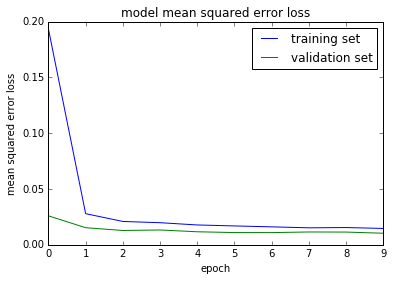

In [36]:
import matplotlib.pyplot as plt

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [16]:
##
## Working code with left, right and centre images
##

# import cv2
# import numpy as np
# import sklearn
# from sklearn.utils import shuffle

# # Hyperparameters - leave these in this position
# batch_size = 256
# epochs = 5
# learn_rate = 0.001
# drop_rate = 0.3

# ## Add multi camera angels (left/right) + Augmentation# Flip the Images for more data   

# def generator(samples, batch_size=32):
#     num_samples = len(samples)
#     while 1: # Loop forever so the generator never terminates
#         shuffle(samples)
#         for offset in range(0, num_samples, batch_size):
#             batch_samples = samples[offset:offset+batch_size]

#             images = []
#             angles = []
#             for batch_sample in batch_samples:
                
#                 # IMAGES
#                 img_center = prepImage(batch_sample[0], img_dir)
#                 images.append(img_center)
                
#                 img_left = prepImage(batch_sample[1], img_dir)
#                 images.append(img_left)
                
#                 img_right = prepImage(batch_sample[2], img_dir)
#                 images.append(img_right)
                
                
#                 # STEERING
#                 steering_center = float(batch_sample[3])
#                 angles.append(steering_center)

#                 correction = 0.2 # this is a parameter to tune
#                 steering_left = steering_center + correction
#                 angles.append(steering_left)
#                 steering_right = steering_center - correction
#                 angles.append(steering_right)


#             # trim image to only see section with road
#             X_train = np.array(images)
#             y_train = np.array(angles)
            
#             yield shuffle(X_train, y_train)
            
# # compile and train the model using the generator function
# train_generator = generator(train_samples, batch_size=batch_size)
# validation_generator = generator(validation_samples, batch_size=batch_size)



In [17]:
##
## Working code with centre images
##
# import cv2
# import numpy as np
# import sklearn
# from sklearn.utils import shuffle

# # Hyperparameters - leave these in this position
# batch_size = 256
# epochs = 10
# learn_rate = 0.001
# drop_rate = 0.3

# ## Add multi camera angels (left/right) + Augmentation# Flip the Images for more data   

# def generator(samples, batch_size=32):
#     num_samples = len(samples)
#     while 1: # Loop forever so the generator never terminates
#         shuffle(samples)
#         for offset in range(0, num_samples, batch_size):
#             batch_samples = samples[offset:offset+batch_size]

#             images = []
#             angles = []
#             for batch_sample in batch_samples:
#                 name = img_dir + batch_sample[0].split('/')[-1]
#                 # Update this for all camera angles
#                 center_image = cv2.imread(name, 1) # 0 = grayscale, 1 = Colour
#                 center_angle = float(batch_sample[3])
#                 images.append(center_image)
#                 angles.append(center_angle)

#             # trim image to only see section with road
#             X_train = np.array(images)
#             y_train = np.array(angles)
#             yield shuffle(X_train, y_train)
            
# # compile and train the model using the generator function
# train_generator = generator(train_samples, batch_size=batch_size)
# validation_generator = generator(validation_samples, batch_size=batch_size)

